# Animal Recognition in Tensorflow

* This is a general guide with notes on the implementation of Computer Vision applications via Tensorflow and Python, the dataset I am using for the purposes of this project can be found [here](https://www.kaggle.com/alessiocorrado99/animals10#OIP---lAIbDlHKmejDpqrXq6vAAAAA.jpeg).

* I wrote this in Jupyter Notebook to make it easier to take notes and make observations especially when implementing the more complicated Inception Networks, but one thing important to note is that the enviornment that Jupyter runs in does not allow for direct hardware access.
    * An interesting fact about Tensorflow that most people know, is that the core feature of Tensorflow involves the creation of a computation graph which is deployed via C++ in the background to the GPU. Which cannot be done in Jupyter
    * When you see the **.fit** method used anywhere and don't see any output it is for this reason, compile this program on your IDE of choice and run .fit there, Jupyter can't access the GPU

#### Goals of this project:
0. [Image loading from directories](#0.-Image-Loading-from-Directories)
<br/><br/>
1. [Pre-processing and Data Augmentation](#1.-Pre-processing-and-Data-Augmentation)
<br/><br/>
2. [Experiment with ILSVRC pre-trained models](#2.-Experiment-with-ILSVRC-pre-trained-models)
<br/><br/>
3. [Experiment with custom model development](#3.-Experiment-with-custom-model-development)
    * Different optimizers
    * loss functions
    * callbacks
<br/><br/>
4. [Implement the Naive inception model](#4.-Implement-the-Naive-inception-model)
<br/><br/>
5. Exporting the model 
    * TF-Slim
    * h5
    * Tensorflow Model Save/Load procedure

In [14]:
directory = 'animals' # Directory of the animal images
animals = ['cat', 'butterfly', 'dog', 'sheep', 'spider', 'chicken', 'horse', 'squirrel', 'cow', 'elephant']
num_classes = len(animals)

# Tensorflow version I plan on using for this project
import tensorflow as tf
print(tf.__version__)

2.0.0


## 0. Image Loading from Directories

### Loading Images using Pillow

Picture of cat


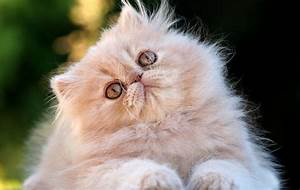

In [2]:
from PIL import Image
import IPython.display as display
import os

file_paths = [] # file_paths for targets
targets = [] # targets

# Parse animal folder and set file_path and targets arrays
for animal in animals:
    animal_dir = os.path.join(directory,animal)
    for file in os.listdir(animal_dir):
        file_paths.append(os.path.join(animal_dir, file))
        targets.append(animals.index(animal))

print('Picture of', animals[targets[0]])
display.display(Image.open(file_paths[0]))

* This is great, but it was a lot of work to do all of this manually, Keras and Tensorflow make it easy

### Loading Images using Keras
* Keras comes with the ability to load images and the Tensorflow website [here](https://www.tensorflow.org/tutorials/load_data/images) has a bunch of great examples on implementation

In [3]:
import tensorflow as tf

import numpy as np
# The 1./255 is to convert from uint8 to float32 in range [0,1]
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

image_count = len(file_paths)
BATCH_SIZE = 32 # 32 for visualization, but 256 is typical for large scale image applications
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = img_gen.flow_from_directory(directory=str(directory), 
                                             follow_links=True,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = (animals))

Found 26179 images belonging to 10 classes.


The code above is pretty straightforward, the keras ImageDataGenerator utility provides an easy way to rescale and load images from paths. However one thing I do want to note is a very useful feature for directories with hierarchies.

In the event that you have folders within folders containing images, i.e: animals/cats/... and animals/dogs/..., you want to pay attention to:

**follow_links = True**

By default this is False, but setting it to True allows the DataGenerator to automatically loop through each individual directory according to the classes list

In [4]:
import matplotlib.pyplot as plt

# You need to turn the classes into a numpy array
animal_np = np.array(animals)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(animal_np[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

This method through Keras is great, but has a ton of problems:
1. Slow
2. No fine-grain control
3. Not integrated with TF directly (harder to troubleshoot when plugging into ConvNet)

### Loading images using tf.data

In [5]:
list_ds = tf.data.Dataset.list_files(str(directory + '/*/*')) # /*/* go down to the files
for f in list_ds.take(5):
  print(f.numpy())

b'animals/elephant/OIP-Ba16VdaMdGXRR2l3FI2ymgAAAA.jpeg'
b'animals/elephant/OIP-TOBWWbk3SeneV972M8EoDwHaEo.jpeg'
b'animals/dog/OIP-pJ1VAsdJQC-hBThqb0VCvQHaFv.jpeg'
b'animals/dog/OIP-ecs9WAYaGo9rIHRtc2_8eAHaJ4.jpeg'
b'animals/sheep/OIP-70zRZxBtEo8qmduJQ-6qbAHaJ4.jpeg'


In [6]:
def decode_img(img):
  # convert the raw string into a 3d tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def get_label_image_pair(file_path):
    
    # Find the class name -----------------------------
    segments = tf.strings.split(file_path, os.path.sep)
    # The second to last is the directory name
    tensor = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    mask = segments[-2] == animals
    label = tf.boolean_mask(tensor, mask) # CONVERT TO ONE-HOT
    
    # Get the image in raw format ---------------------
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(get_label_image_pair) #num_parallel_calls=tf.data.experimental.AUTOTUNE)

labeled_ds = labeled_ds.shuffle(buffer_size=1000).batch(32)
    
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", len(label.numpy()), label.dtype)

Image shape:  (32, 224, 224, 3)
Label:  32 <dtype: 'int32'>


I'll be using the tensorflow.data method of loading images in order to make the process of image augmentation easier

## 1. Pre-processing and Data Augmentation
* This still needs to be completed

## 2. Experiment with ILSVRC pre-trained models
* Now we have a completed dataset, the next step is to mess around with some of the basic models from the ImageNet Large Scale Visual Recognition Challenge, a competition that standardized basic CV models for use in the industry. It ran until the models produced achieved accuracy better than a human.

Loading the ILSVRC models in Tensorflow has been made really easy with the model downloading features introduced to TF. 

* The goals of this section of the project are as follows:
    * Download multiple popular ILSVRC models
    * Experiment with fitting the data
    * Experiment with different compilers and loss functions + trade-offs
    * Analyze model architecture
    
### Downloading the models
#### VGG - Visual Geometry Group @ Oxford (2014 2nd place)
* Made use of **ReLU** (Rectified Linear Unit) as activation function common in CNNs for adding non-linearity
* Applied **dropout** to CNN architecture
* Standardized structure of CNN layers --> Dense (Fully-Connected) layers

In [7]:
vgg_net = tf.keras.applications.VGG16(
    include_top = True, weights=None, # you can set weights to 'imagenet'
    input_tensor=None, input_shape = None, pooling = None, 
    classes = 10 # 1000 for imagenet weights
)

vgg_net.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [8]:
print(vgg_net.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# vgg_net.fit(labeled_ds, epochs=200, verbose=1)

## 3. Experiment with custom model development
* Goals in this portion of the project
    * Different optimizers
    * loss functions
    * callbacks
    * Experiment with Tensorboard

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
input_shape = (224, 224, 3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(1,1), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(68, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [11]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", len(label.numpy()), label.dtype)

Image shape:  (32, 224, 224, 3)
Label:  32 <dtype: 'int32'>


In [12]:
#model.fit(labeled_ds, epochs=2, verbose=1)
# You can run this on your computer

![verbosity](verbosity.png)
* Here is an example of the training view, I can't complete training on my MacBookPro without risking overheating, but I began training to get an idea of how the process works for a dataset of this size
![Training procedure](training.png)

## 4. Implement the Naive inception model
* Below is an introduction to GoogLeNet and the inception module

### GoogLeNet
* Developed by Google, architecture won first place in 2014
* 21 times lighter than VGG-16 above
#### The Inception Module
* The key breakthrough of the GoogLeNet architecture was the development of the **inception module**
    * A sub-network that can perform parallel processing
    * The input is put through two layers and the output of each is concatenated together in a process called **depth concatenation**
##### Versions of the Inception Module
![Inception Modules](https://miro.medium.com/max/2698/1*aq4tcBl9t5Z36kTDeZSOHA.png)
* 1x1 Convolutions are called **bottlenecks** that perform compression in order to reduce parametric weight
##### Average Pooling
* Introducing average pooling after the convolutional block further reduces parametric weight and the computational advantage is incredible --> You do lose some info, but not enough to make the addition of AvgPooling not worth it

### Contructing the Network with Tensorflow and Keras
* Taking an object-oriented approach to the implementation of the Inception Module using the Functional API of Keras